In [1]:
import csv
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapefile as shp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import sup_func as sfu
%matplotlib inline

#I get the df from website worldometers.info

url_popu = 'https://www.worldometers.info/world-population/population-by-country/'
url_covid = 'https://www.worldometers.info/coronavirus/#countries'
r_popu = requests.get(url_popu)
r_covid = requests.get(url_covid)
soup_popu = BeautifulSoup(r_popu.content)
soup_covid = BeautifulSoup(r_covid.content)
countries_popu = soup_popu.find_all('table')[0]
countries_covid = soup_covid.find_all('table')[0]
df_popu = pd.read_html(str(countries_popu))[0]
df_covid = pd.read_html(str(countries_covid))[0]
df_popu.head()

,#,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,1,China,1439323776,0.39 %,5540090,153,9388211,-348399.0,1.7,38,61 %,18.47 %
1,2,India,1380004385,0.99 %,13586631,464,2973190,-532687.0,2.2,28,35 %,17.70 %
2,3,United States,331002651,0.59 %,1937734,36,9147420,954806.0,1.8,38,83 %,4.25 %
3,4,Indonesia,273523615,1.07 %,2898047,151,1811570,-98955.0,2.3,30,56 %,3.51 %
4,5,Pakistan,220892340,2.00 %,4327022,287,770880,-233379.0,3.6,23,35 %,2.83 %


In [2]:
df_covid.head()

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/ 1M pop
0,World,3096702,"+34,187",213539.0,"+2,090",938571.0,1944592,56113.0,397.0,27.4,NaN,NaN
1,USA,1014541,"+4,185",57065.0,+268,139555.0,817921,14187.0,3065.0,172.0,5728565.0,17307.0
2,Spain,232128,"+2,706",23822.0,+301,123903.0,84403,7764.0,4965.0,510.0,1345560.0,28779.0
3,Italy,201505,"+2,091",27359.0,+382,68941.0,105205,1863.0,3333.0,453.0,1846934.0,30547.0
4,France,165842,NaN,23293.0,NaN,45513.0,97036,4608.0,2541.0,357.0,463662.0,7103.0


In [3]:
#I get the columns that I want to use from df_popu

df_raw = pd.DataFrame({'A' : []})
df_raw['Country (or dependency)'] = df_popu['Country (or dependency)']
df_raw['Population (2020)'] = df_popu['Population (2020)']
df_raw['Density (P/Km²)'] = df_popu['Density (P/Km²)']
df_raw['Land Area (Km²)'] = df_popu['Land Area (Km²)']
df_raw['Migrants (net)'] = df_popu['Migrants (net)']
df_raw['Med. Age'] = df_popu['Med. Age']
df_raw['Urban Pop %'] = df_popu['Urban Pop %']
df_raw = df_raw.dropna(how='all',axis=1)
df_raw.head()

,Country (or dependency),Population (2020),Density (P/Km²),Land Area (Km²),Migrants (net),Med. Age,Urban Pop %
0,China,1439323776,153,9388211,-348399.0,38,61 %
1,India,1380004385,464,2973190,-532687.0,28,35 %
2,United States,331002651,36,9147420,954806.0,38,83 %
3,Indonesia,273523615,151,1811570,-98955.0,30,56 %
4,Pakistan,220892340,287,770880,-233379.0,23,35 %


In [4]:

#After checking both countries columns, I try match both columns with below dictionary
country_dic = {'USA':'United States', 'UK':'United Kingdom', 'S. Korea':'South Korea', 'UAE':'United Arab Emirates',
               'Czechia':'Czech Republic (Czechia)', 'Ivory Coast':"Côte d'Ivoire", 'DRC':'DR Congo',
               'Palestine':'State of Palestine', 'CAR':'Central African Republic', 'Saint Kitts and Nevis':'Saint Kitts & Nevis',
               'St. Vincent Grenadines':'St. Vincent & Grenadines', 'Vatican City':'Holy See', 'St. Barth':'Saint Barthelemy',
               'Sao Tome and Principe':'Sao Tome & Principe', 'Saint Pierre Miquelon':'Saint Pierre & Miquelon'}
df_covid['Country (or dependency)'] = df_covid['Country,Other']
df_covid.replace({'Country (or dependency)': country_dic},  inplace = True)
#I remove the columns from df_covid that I am not interested in 
df_subs = df_covid.drop([df_covid.columns[8],'Country,Other','NewCases','NewDeaths','ActiveCases','Serious,Critical','Tests/ 1M pop','Deaths/1M pop'],axis=1)
df_subs.head()

,TotalCases,TotalDeaths,TotalRecovered,TotalTests,Country (or dependency)
0,3096702,213539.0,938571.0,NaN,World
1,1014541,57065.0,139555.0,5728565.0,United States
2,232128,23822.0,123903.0,1345560.0,Spain
3,201505,27359.0,68941.0,1846934.0,Italy
4,165842,23293.0,45513.0,463662.0,France


In [5]:
#I join both tables using as index the country
df_raw = df_raw.join(df_subs.set_index('Country (or dependency)'), on='Country (or dependency)')
df_raw.head()

,Country (or dependency),Population (2020),Density (P/Km²),Land Area (Km²),Migrants (net),Med. Age,Urban Pop %,TotalCases,TotalDeaths,TotalRecovered,TotalTests
0,China,1439323776,153,9388211,-348399.0,38,61 %,82836.0,4633.0,77555.0,NaN
1,India,1380004385,464,2973190,-532687.0,28,35 %,29451.0,939.0,7137.0,716733.0
2,United States,331002651,36,9147420,954806.0,38,83 %,1014541.0,57065.0,139555.0,5728565.0
3,Indonesia,273523615,151,1811570,-98955.0,30,56 %,9511.0,773.0,1254.0,79618.0
4,Pakistan,220892340,287,770880,-233379.0,23,35 %,14079.0,301.0,3233.0,157223.0


In [6]:
#I have called dtypes to check where I have non-numeric columns to change its type.
df_raw.dtypes

Country (or dependency)     object
Population (2020)            int64
Density (P/Km²)              int64
Land Area (Km²)              int64
Migrants (net)             float64
Med. Age                    object
Urban Pop %                 object
TotalCases                 float64
TotalDeaths                float64
TotalRecovered             float64
TotalTests                 float64
dtype: object

In [7]:
#lets start for Urban POP, I change % values to floats, 100% is 1 0% is 0
indexes = df_raw.index.values.tolist()
for index in indexes:
    per = df_raw.loc[index,'Urban Pop %']
    if per == 'N.A.':
        df_raw.loc[index,'Urban Pop %'] = np.nan
    else:
        if type(per) is str:
            if per == '0 %':
                df_raw.loc[index,'Urban Pop %'] = 0
            else:
                df_raw.loc[index,'Urban Pop %'] = int(per[0:2])/100

df_raw = df_raw.astype({'Urban Pop %': 'float64'})
#Now I change the countries name to a number and replace the name with the number in the df
countries_list = df_raw['Country (or dependency)'].unique()
countries_list.sort()
countries_dic = dict()
k=0
for country in countries_list:
    countries_dic[country] = k
    k +=1
dic_reverse = {}
for key,values in countries_dic.items():
    dic_reverse[values] = key

df_raw.replace({'Country (or dependency)': countries_dic},  inplace = True)
#the last one is the Med Age. I change to a numeric, using coerce (imput NAN to errors)
df_raw['Med. Age'] = pd.to_numeric(df_raw['Med. Age'],errors='coerce')
df_raw.dtypes

Country (or dependency)      int64
Population (2020)            int64
Density (P/Km²)              int64
Land Area (Km²)              int64
Migrants (net)             float64
Med. Age                   float64
Urban Pop %                float64
TotalCases                 float64
TotalDeaths                float64
TotalRecovered             float64
TotalTests                 float64
dtype: object

In [8]:
#I am going to add a column of countries with free healthcare, migth be usefull
df_healthcare = pd.read_csv('countries with free healthcare.csv')
hc_edit = {'Czech Republic':'Czech Republic (Czechia)',
           'Macau':'Macao',
           'Saint Vincent and the Grenadines':'St. Vincent & Grenadines'}
df_healthcare.replace({'name': hc_edit},  inplace = True)
df_healthcare['free healthcare'] = 1
df_healthcare.drop(['pop2020'], axis=1, inplace=True)
df_healthcare.replace({'name': countries_dic},  inplace = True)
df_healthcare.head()

,name,free healthcare
0,1,1
1,2,1
2,4,1
3,7,1
4,8,1


In [9]:
df_raw = df_raw.join(df_healthcare.set_index('name'), on='Country (or dependency)')
df_raw['free healthcare'].fillna(0, inplace=True)

#now I am ready with my df, everything is a number

df_raw.dtypes

Country (or dependency)      int64
Population (2020)            int64
Density (P/Km²)              int64
Land Area (Km²)              int64
Migrants (net)             float64
Med. Age                   float64
Urban Pop %                float64
TotalCases                 float64
TotalDeaths                float64
TotalRecovered             float64
TotalTests                 float64
free healthcare            float64
dtype: object

In [10]:
#3 possible evaluations, TotalCases, TotalDeaths and TotalRecovered
casos = ['TotalCases','TotalDeaths','TotalRecovered']
for caso in casos:
    X, y = sfu.edit_df(df_raw,caso)
    r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = sfu.get_stat_data(X,y)
    print("{} case: The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(caso,r2_scores_train,r2_scores_test))
    

TotalCases case: The rsquared on the training data was 0.8873637226417841.  The rsquared on the test data was -0.09257676047266128.
TotalDeaths case: The rsquared on the training data was 0.3600376002669061.  The rsquared on the test data was 0.5676146547903681.
TotalRecovered case: The rsquared on the training data was 0.5976266470904756.  The rsquared on the test data was 0.7147295380778333.


In [11]:
X, y = sfu.edit_df(df_raw, 'TotalRecovered')
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = sfu.get_stat_data(X,y)

coef_df = sfu.coef_weights(lm_model.coef_, X_train)
coef_df

,est_int,coefs,abs_coefs
6,Urban Pop %,3193.941475,3193.941475
8,free healthcare,2374.749169,2374.749169
5,Med. Age,116.805683,116.805683
0,Country (or dependency),-9.463385,9.463385
2,Density (P/Km²),-0.212953,0.212953
7,TotalTests,0.022517,0.022517
4,Migrants (net),0.021887,0.021887
3,Land Area (Km²),-0.002521,0.002521
1,Population (2020),0.000042,0.000042


In [12]:
X, y = sfu.edit_df(df_raw, 'TotalCases')
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = sfu.get_stat_data(X,y)

coef_df = sfu.coef_weights(lm_model.coef_, X_train)
coef_df

,est_int,coefs,abs_coefs
8,free healthcare,-2064.625826,2064.625826
6,Urban Pop %,1492.478622,1492.478622
5,Med. Age,-669.114413,669.114413
0,Country (or dependency),-35.211321,35.211321
4,Migrants (net),0.219650,0.219650
2,Density (P/Km²),-0.209107,0.209107
7,TotalTests,0.135207,0.135207
3,Land Area (Km²),-0.015192,0.015192
1,Population (2020),0.000151,0.000151


In [13]:
X, y = sfu.edit_df(df_raw, 'TotalDeaths')
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = sfu.get_stat_data(X,y)

coef_df = sfu.coef_weights(lm_model.coef_, X_train)
coef_df

,est_int,coefs,abs_coefs
6,Urban Pop %,909.749686,909.749686
8,free healthcare,204.996091,204.996091
5,Med. Age,31.917145,31.917145
0,Country (or dependency),-4.026753,4.026753
2,Density (P/Km²),-0.875309,0.875309
7,TotalTests,0.006366,0.006366
3,Land Area (Km²),-0.000818,0.000818
4,Migrants (net),0.000766,0.000766
1,Population (2020),0.000005,0.000005


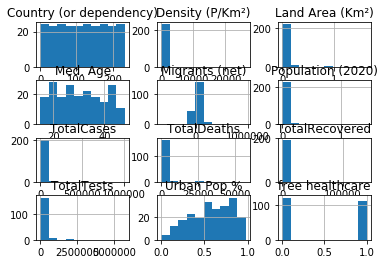

In [14]:
df_raw.hist();

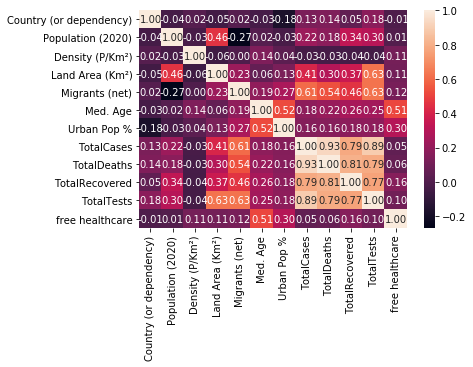

In [15]:
sns.heatmap(df_raw.corr(), annot= True, fmt='.2f');

In [16]:
df_chart = pd.DataFrame()
df_chart2 = pd.DataFrame()
df_chart3 = pd.DataFrame()
df_chart4 = pd.DataFrame()
df_c = pd.DataFrame()
dic_fh = {1: 'Yes', 0:'No'}
df_raw.head()

,Country (or dependency),Population (2020),Density (P/Km²),Land Area (Km²),Migrants (net),Med. Age,Urban Pop %,TotalCases,TotalDeaths,TotalRecovered,TotalTests,free healthcare
0,43,1439323776,153,9388211,-348399.0,38.0,0.61,82836.0,4633.0,77555.0,NaN,1.0
1,96,1380004385,464,2973190,-532687.0,28.0,0.35,29451.0,939.0,7137.0,716733.0,0.0
2,224,331002651,36,9147420,954806.0,38.0,0.83,1014541.0,57065.0,139555.0,5728565.0,0.0
3,97,273523615,151,1811570,-98955.0,30.0,0.56,9511.0,773.0,1254.0,79618.0,0.0
4,158,220892340,287,770880,-233379.0,23.0,0.35,14079.0,301.0,3233.0,157223.0,1.0


In [17]:
df_chart['Free Healthcare'] = df_raw['free healthcare']
df_chart['Population (2020)'] = df_raw['Population (2020)']
df_chart['TotalCases'] = df_raw['TotalCases']
df_chart.replace({'Free Healthcare':dic_fh}, inplace = True)
grouped_df = df_chart.groupby('Free Healthcare').sum()
grouped_df['Cases per 1M P'] = (grouped_df['TotalCases']*1e6)/grouped_df['Population (2020)']

In [18]:
grouped_df

,Population (2020),TotalCases,Cases per 1M P
Free Healthcare,,,
No,3966933941,1145481.0,288.757266
Yes,3827864798,1950500.0,509.553002


In [19]:
df_chart2['Free Healthcare'] = df_raw['free healthcare']
df_chart2['Population (2020)'] = df_raw['Population (2020)']
df_chart2['TotalDeaths'] = df_raw['TotalDeaths']
df_chart2.replace({'Free Healthcare':dic_fh}, inplace = True)
grouped_df2 = df_chart2.groupby('Free Healthcare').sum()
grouped_df2['Deaths per 1M P'] = (grouped_df2['TotalDeaths']*1e6)/grouped_df2['Population (2020)']

In [20]:
grouped_df2

,Population (2020),TotalDeaths,Deaths per 1M P
Free Healthcare,,,
No,3966933941,62585.0,15.776668
Yes,3827864798,150939.0,39.431643


In [21]:
df_chart3['Free Healthcare'] = df_raw['free healthcare']
df_chart3['Population (2020)'] = df_raw['Population (2020)']
df_chart3['TotalRecovered'] = df_raw['TotalRecovered']
df_chart3.replace({'Free Healthcare':dic_fh}, inplace = True)
grouped_df3 = df_chart3.groupby('Free Healthcare').sum()
grouped_df3['Recovered per 1M P'] = (grouped_df3['TotalRecovered']*1e6)/grouped_df3['Population (2020)']

In [22]:
grouped_df3

,Population (2020),TotalRecovered,Recovered per 1M P
Free Healthcare,,,
No,3966933941,174831.0,44.072072
Yes,3827864798,762501.0,199.197474


In [23]:
df_c['Free Healthcare'] = df_raw['free healthcare']
df_c.replace({'Free Healthcare':dic_fh}, inplace = True)
df_c['Population (2020)'] = df_raw['Population (2020)']
group_dfc2 = df_c.groupby('Free Healthcare').agg({'count','sum'})
df_c['TotalCases'] = df_raw['TotalCases']
df_c['TotalDeaths'] = df_raw['TotalDeaths']
df_c['TotalRecovered'] = df_raw['TotalRecovered']
df_c['TotalTests'] = df_raw['TotalTests']
group_dfc = df_c.groupby('Free Healthcare').sum()
group_dfc['Tests per 1M P']= (group_dfc['TotalTests']*1e6)/group_dfc['Population (2020)']
group_dfc['Cases per 1M P']= (group_dfc['TotalCases']*1e6)/group_dfc['Population (2020)']
group_dfc['Deaths per 100 Cases'] = (group_dfc['TotalDeaths']*100)/group_dfc['TotalCases']
group_dfc['Recovered per 100 Cases'] = (group_dfc['TotalRecovered']*100)/group_dfc['TotalCases']
rate_expected = group_dfc.loc['No','Cases per 1M P']/group_dfc.loc['Yes','Cases per 1M P']


In [24]:
group_dfc

,Population (2020),TotalCases,TotalDeaths,TotalRecovered,TotalTests,Tests per 1M P,Cases per 1M P,Deaths per 100 Cases,Recovered per 100 Cases
Free Healthcare,,,,,,,,,
No,3966933941,1145481.0,62585.0,174831.0,8220413.0,2072.233398,288.757266,5.463644,15.262671
Yes,3827864798,1950500.0,150939.0,762501.0,21566428.0,5634.062105,509.553002,7.738477,39.092592


In [25]:
group_dfc2

Population (2020)            
                            count         sum
Free Healthcare                              
No                            123  3966933941
Yes                           112  3827864798

In [27]:
x = 122387238913
y= sfu.popu_cifra(x) 
y

'122.39B'

In [28]:
sns.set(style='whitegrid', palette='pastel', color_codes=True)

In [29]:
sns.mpl.rc('figure', figsize=(10,6))

In [30]:
#opening the vector map
shp_path = 'World_Countries.shp'
#reading the shape file by using reader function of the shape lib
sf = shp.Reader(shp_path)

In [31]:
len(sf.shapes())

252

In [32]:
sf.records()[0]
    


Record #0: ['Aruba (Netherlands)']

In [33]:
df = sfu.read_shapefile(sf)

In [36]:
df.head()

,COUNTRY,coords
0,Aruba (Netherlands),"[(-69.88223266601562, 12.411109924316406), (-6..."
1,Antigua and Barbuda,"[(-61.7388916015625, 17.54055404663086), (-61...."
2,Afghanistan,"[(61.27655792236328, 35.60724639892578), (61.2..."
3,Algeria,"[(-5.152134895324707, 30.180469512939453), (-5..."
4,Azerbaijan,"[(46.540374755859375, 38.875587463378906), (46..."


In [46]:
com_id = df.index[df['COUNTRY'] == 'Algeria'][0]


In [47]:
com_id

3

In [50]:
sfu.plot_shape(com_id, 'COUNTRY')
sf.shape(com_id)

AttributeError: module 'sup_func' has no attribute 'plot_shape'